40/40 - 5s - loss: 0.1432 - accuracy: 0.9568

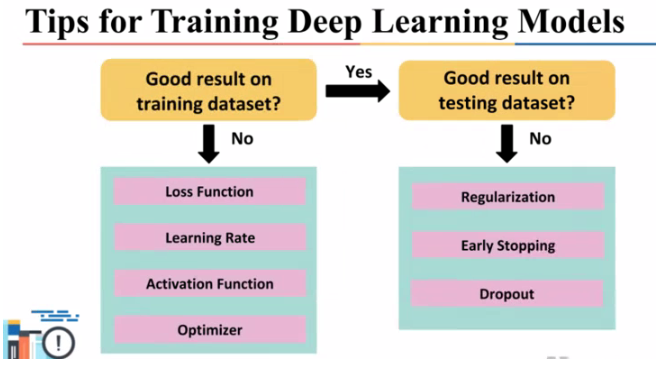

# Pre-Trained: DenseNet

改善 CNN 模型準確率的幾種改進方法：<br>

1. data augmentation。參考 code: ex_CNN_where_am_i_augmentation.ipynb。更多的 aug: https://github.com/aleju/imgaug<br>
2. Batch Normalization, Intializer, GlobalPooling，用 GlobalPooling 取代 Dense layer，可以有效減少參數。參考 code: ex_CNN_where_am_i_advanced.ipynb<br>
3. 加深網路架構 (多疊幾層 conv，甚至使用 Residual block)、增加影像解析度 (image size 變大)、擴增網路寬度 (類似 inception 的架構)，可以參考 efficientnet 設計理念。<br>
4. learning rate 隨著迭代次數遞減 or 若 val_loss 幾次內沒有下降則降低 learning rate。參考網址: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau<br>
5. 根據資料不平衡，使用 class_weights、SMOTE、Weight Normalization 等方法。參考網址: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data<br>
6.使用較新的 activation function 取代 relu，例如 leakyrelu, swish, mish，這些 activation 可以把負值的資訊也學起來。參考網址: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation<br>

In [1]:
version = '1_2'
import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Check GPU
import tensorflow as tf

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# config.gpu_options.allow_growth =true  #按需求使用gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.test.gpu_device_name()  

'/device:GPU:0'

In [6]:
is_gpu = len(tf.config.experimental.list_physical_devices('GPU')) > 0
print(is_gpu)

True


In [7]:
# import package
import tensorflow.keras as keras
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D)

In [8]:
# !pip install imblearn

In [9]:
# data_path = "../image_cbamuse"
data_path = "../image"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("/")[-1])

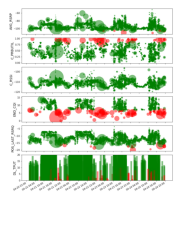

In [10]:
img = cv2.imread(x_data_list[0])[:, :, ::-1]
plt.imshow(img)
plt.axis("off")
plt.show()

In [11]:
img.shape

(936, 720, 3)

In [12]:
img_size = 224

In [13]:
def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each, 1)
        img = cv2.resize(img, (img_size, img_size))
        data_img.append(img[..., np.newaxis])
        
#         if img is None:
#             print('Wrong path:')
#         else:
#             img = cv2.resize(img, (img_size, img_size))
            
    return np.array(data_img).astype('float32')/255.
x_data = load_img(x_data_list)

100%|██████████| 12505/12505 [01:15<00:00, 166.33it/s]


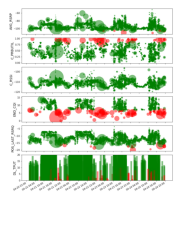

In [14]:
img = cv2.imread(x_data_list[0])[:, :, ::-1]
plt.imshow(img)
plt.axis("off")
plt.show()

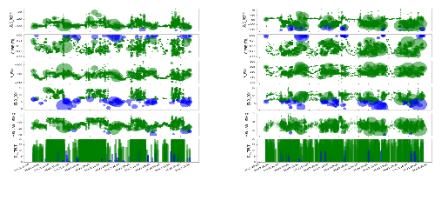

In [15]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_data[i][..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [16]:
y_data_list = pd.DataFrame(y_data_list, columns=['label'])
uniques = y_data_list['label'].value_counts().index
counts = y_data_list['label'].value_counts().values

In [17]:
print(uniques , counts)

Index(['HighPRB', 'Interfere', 'NoAbnormal', 'PrbSignalNoGood',
       'SignalNoGood'],
      dtype='object') [2501 2501 2501 2501 2501]


In [18]:
# # find ./practice -name "aug_*.jpg"  -exec rm {} \;
# datagen = ImageDataGenerator(
# #                              rotation_range=45,
# #                              brightness_range=[0.5, 1.5],
# #                              width_shift_range=[0.1,0.5],
# #                              height_shift_range=[0.1,0.5],
# #                              shear_range=[0.1,0.5], 會報錯
# #                              zoom_range=[0.5, 1.5],
# #                              rescale = 1 / 255.,
# #                              horizontal_flip=True,
# #                              vertical_flip=False,
# #                              fill_mode='nearest'
#                              )

In [19]:
# data_path = "/home/jovyan/practice/99_Testing/where_am_i/train/"

# for a, b in enumerate(uniques):
#     picdir1 = data_path
#     picdir2 = data_path + '/' + b 

#     c = 2500-counts[a]
#     print(picdir2)
#     print(c)
#     i=0
#     for batch in datagen.flow_from_directory(directory=picdir1,
#                                             classes=[b],
#                                             batch_size=1,
#                                             target_size=(224,224),
# # #                                             color_mode='1',
# #                                             class_mode=None,
#                                             save_to_dir=picdir2,
#                                             save_prefix='aug',
#                                             save_format='png'):
#         i += 1
#         if i > c :
#             break

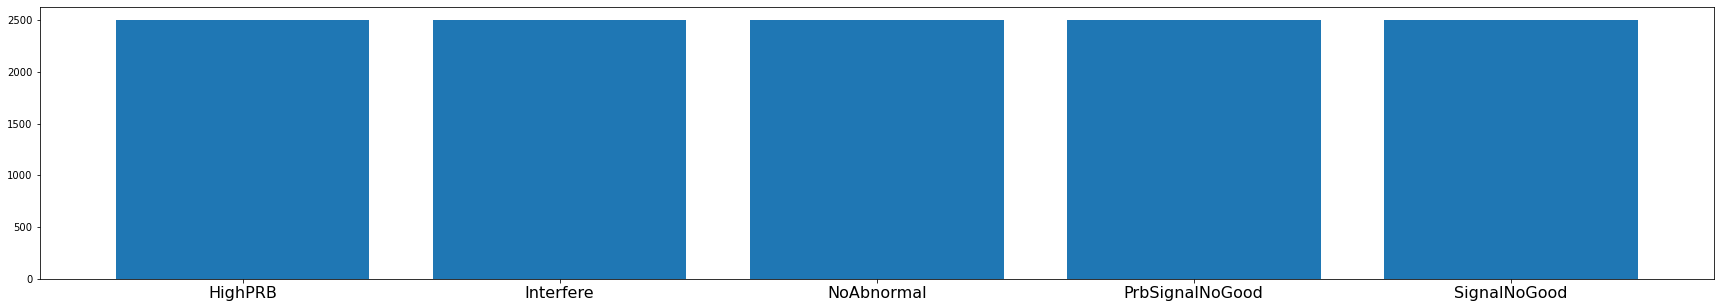

In [20]:
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [21]:
y_data = y_data_list

In [22]:
print(x_data.shape)
print(y_data_list.shape)
print(y_data.shape)

(12505, 224, 224, 3, 1)
(12505, 1)
(12505, 1)


In [23]:
x_data = np.squeeze(x_data)

In [24]:
print(x_data.shape)

(12505, 224, 224, 3)


### 資料前處理

Resize

In [25]:
x_data.shape

(12505, 224, 224, 3)

In [26]:
# 將資料切分為訓練集和測試集
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.1,
                                                    random_state=10,
                                                    stratify=y_data
                                                   )

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data,
                                                    test_size=0.1 ,
                                                    random_state=10
                                                     )

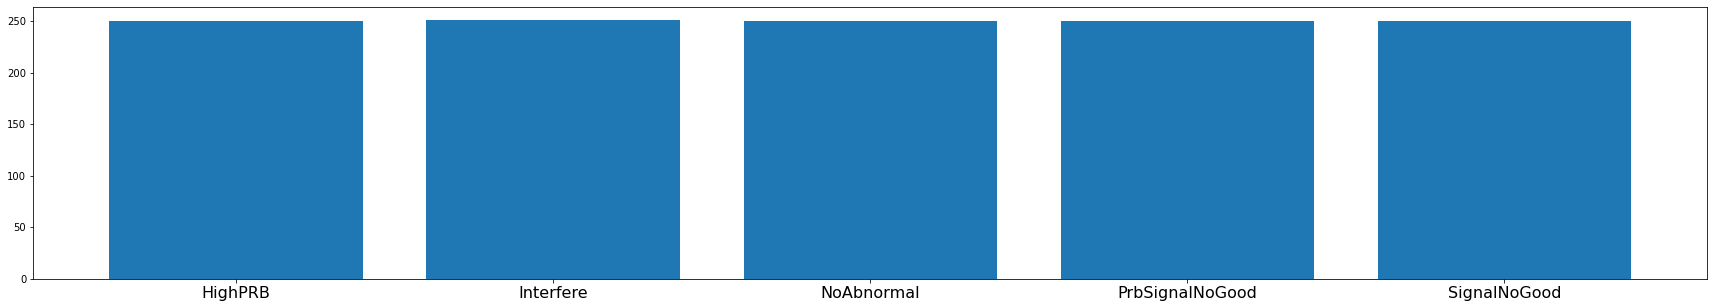

In [27]:
uniques, counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [28]:
from sklearn.preprocessing import LabelEncoder

num_classes = len(uniques)

label_encoder = LabelEncoder()
y_train1 = y_train.values.ravel()
y_valid1 = y_valid.values.ravel()
y_train1 = label_encoder.fit_transform(y_train1)
y_valid1 = label_encoder.fit_transform(y_valid1)

y_train = tf.keras.utils.to_categorical(y_train1, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid1, num_classes)

print('y_train shape:', y_train1.shape)

y_train shape: (11254,)


In [29]:
num_classes

5

In [30]:
print(y_train1[0:10])

[3 0 1 2 0 0 3 2 1 4]


# 準備建模型

In [31]:
def call_list_fun(models, model_name):
    model_dir = './Model/{}-logs'.format(model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    logfiles = model_dir + '/{}-{}'.format('basic_model',
                                           models.__class__.__name__)
    model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                            histogram_freq=1)

#     modelfiles = model_dir + '/{}-dense_v'+ version +'.h5'.format('basic_model')
    modelfiles = model_dir + '/{}-denseCBAM_v1_2.h5'.format('basic_model')

    model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                                 monitor='val_accuracy',
                                                 save_best_only=True, verbose=1)
    
#     change_lr = LearningRateScheduler(scheduler)
    lr_schedule = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=20,
                                              verbose=2)
#     return [model_cbk, model_mckp, earlystop]
    return [model_cbk, model_mckp, lr_schedule]

In [32]:
def schedule(epoch):  # 定義 learning rate 根據 epoch 要如何變動
    if epoch < 3:
        return 0.001
    elif epoch < 7:
        return 0.0001
    elif epoch < 10:
        return 0.00001
    elif epoch < 15:
        return 0.000001    
    else:
        return 0.0000001

In [33]:
batch_size = 32 #32=>64
epochs = 20

## 加入 BatchNormalization

In [34]:
x_train.shape

(11254, 224, 224, 3)

In [35]:
from tensorflow.keras import initializers

initial = initializers.he_normal()

In [36]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, ReLU
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet201

import matplotlib.pyplot as plt
import pandas as pdc
import numpy as np
import os
import cv2
import glob
import tensorflow as tf

from time import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

#（1）通道注意力
def channel_attenstion(inputs, ratio=0.25):  
    '''ratio代表第一个全连接层下降通道数的倍数'''

    channel = inputs.shape[-1]  # 获取输入特征图的通道数

    # 分别对输出特征图进行全局最大池化和全局平均池化
    # [h,w,c]==>[None,c]
    x_max = layers.GlobalMaxPooling2D()(inputs)
    x_avg = layers.GlobalAveragePooling2D()(inputs)

    # [None,c]==>[1,1,c]
    x_max = layers.Reshape([1,1,-1])(x_max)  # -1代表自动寻找通道维度的大小
    x_avg = layers.Reshape([1,1,-1])(x_avg)  # 也可以用变量channel代替-1

    # 第一个全连接层通道数下降1/4, [1,1,c]==>[1,1,c//4]
    x_max = layers.Dense(channel*ratio)(x_max)
    x_avg = layers.Dense(channel*ratio)(x_avg)

    # relu激活函数
    x_max = layers.Activation('relu')(x_max)
    x_avg = layers.Activation('relu')(x_avg)

    # 第二个全连接层上升通道数, [1,1,c//4]==>[1,1,c]
    x_max = layers.Dense(channel)(x_max)
    x_avg = layers.Dense(channel)(x_avg)

    # 结果在相叠加 [1,1,c]+[1,1,c]==>[1,1,c]
    x = layers.Add()([x_max, x_avg])

    # 经过sigmoid归一化权重
    x = tf.nn.sigmoid(x)

    # 输入特征图和权重向量相乘，给每个通道赋予权重
    x = layers.Multiply()([inputs, x])  # [h,w,c]*[1,1,c]==>[h,w,c]

    return x

#（2）空间注意力机制
def spatial_attention(inputs):

    # 在通道维度上做最大池化和平均池化[b,h,w,c]==>[b,h,w,1]
    # keepdims=Fale那么[b,h,w,c]==>[b,h,w]
    x_max = tf.reduce_max(inputs, axis=3, keepdims=True)  # 在通道维度求最大值
    x_avg = tf.reduce_mean(inputs, axis=3, keepdims=True)  # axis也可以为-1

    # 在通道维度上堆叠[b,h,w,2]
    x = layers.concatenate([x_max, x_avg])

    # 1*1卷积调整通道[b,h,w,1]
    x = layers.Conv2D(filters=1, kernel_size=(1,1), strides=1, padding='same')(x)

    # sigmoid函数权重归一化
    x = tf.nn.sigmoid(x)

    # 输入特征图和权重相乘
    x = layers.Multiply()([inputs, x])

    return x

#（3）CBAM注意力
def CBAM_attention(inputs):

    # 先经过通道注意力再经过空间注意力
    x = channel_attenstion(inputs)
    x = spatial_attention(x)
    return x

In [38]:
img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))
x = base_model.output

x = CBAM_attention(x)

x = Dropout(0.3)(x) #0.4->0.3

x = GlobalAveragePooling2D(data_format='channels_last')(x)

x = Dropout(0.3)(x) #0.4->0.3
# x = Dense(128, activation='relu', name='c')(x)
# x = Dropout(0.5)(x) #0.3->0.4
# x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
# x = Activation('elu')(x)
x = Dropout(0.2)(x) # 新增

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
callbacks_list = call_list_fun(model, 'model')

In [39]:
print(tf.version.VERSION)

2.3.4


In [40]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [41]:
optimizer = keras.optimizers.Adam(lr=1e-5)
# optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [42]:
model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

## 開始訓練模型 (Data augmentation 參數設置)

In [43]:
!nvidia-smi

Wed Sep 14 03:30:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |  14222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
num_step = x_train.shape[0] // batch_size + 1

In [45]:
from datetime import datetime
result = datetime.now().strftime("%Y-%m-%d %H:%M:%S %p")
print(result)

2022-09-14 03:30:14 AM


In [ ]:
history = model.fit(x_train, y_train,
                                  batch_size=batch_size,
#                                   steps_per_epoch=num_step,
                                  epochs=epochs,
                                  validation_data=(x_valid, y_valid),
                                  callbacks=callbacks_list)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
  1/352 [..............................] - ETA: 0s - loss: 1.8948 - accuracy: 0.2812WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
352/352 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8552
Epoch 00001: val_accuracy improved from -inf to 0.81535, saving model to ./Model/model-logs/basic_model-denseCBAM_v1_2.h5
352/352 [==============================] - 193s 549ms/step - loss: 0.4085 - accuracy: 0.8552 - val_loss: 0.5146 - val_accuracy: 0.8153

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9193
Epoch 0

## 訓練結果視覺化

loss, acc = model.evaluate(x_test, y_test, verbose=2)

In [ ]:
loss, acc = model.evaluate(x_valid, y_valid, verbose=2)

40/40 - 5s - loss: 0.1432 - accuracy: 0.9568


In [ ]:
y_pred = model.predict(x_valid)
y_pred = y_pred.argmax(-1)

---

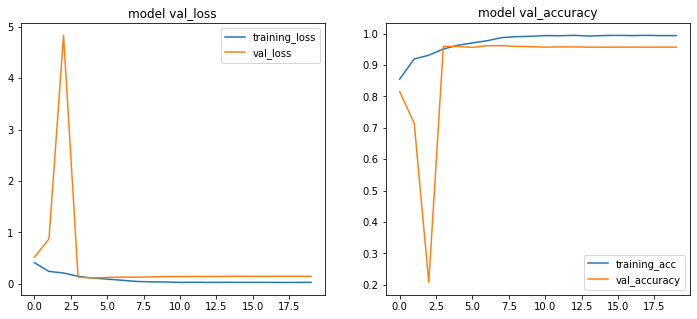

In [ ]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_accuracy']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)
plt.show()

In [ ]:
data_path = "../image_test"

x_test_list = []
cott_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_test_list.append(os.path.join(roots, each))
            cott_list.append(each[:-4]) #檔名

In [ ]:
x_test_list[1]

'../image_test/M2204290018.png'

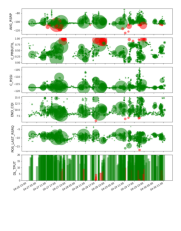

In [ ]:
img = cv2.imread(x_test_list[0])[:, :, ::-1]
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
img_size = 224

In [ ]:
def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each, 1)
        img = cv2.resize(img, (img_size, img_size))
        data_img.append(img[..., np.newaxis])

    return np.array(data_img).astype('float32')/255.
x_test = load_img(x_test_list)

100%|██████████| 250/250 [00:02<00:00, 97.07it/s]


In [ ]:
print(x_test.shape)

(250, 224, 224, 3, 1)


In [ ]:
x_test = np.squeeze(x_test)

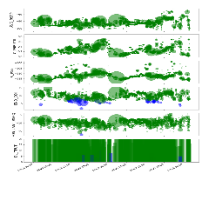

In [ ]:
# show image
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.imshow(x_test[1]) #, cmap='gray'
plt.axis('off')
plt.show()

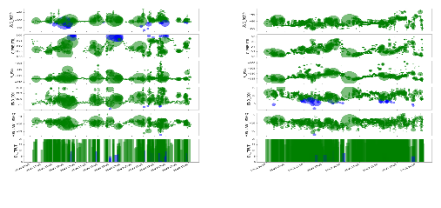

In [ ]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_test[i]) #[..., 0], cmap='gray'
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import Model, load_model
model = load_model('./Model/model-logs/basic_model-denseCBAM_v'+ version +'.h5')
# model = load_model('./Model/model-logs/basic_model-dense_v'+version+'.h5')

In [ ]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, 1)
len(predicted)

250

In [ ]:
# 組合工單編號, 預測 reason
predict_submission = pd.DataFrame({'cott':cott_list, 'predict_reason_code': predicted})

In [ ]:
predict_submission.head()

,cott,predict_reason_code
0,M2204300189,3
1,M2204290018,2
2,M2204250228,2
3,M2204281321,1
4,M2204271002,1


In [ ]:
class_map = pd.read_csv('./class_mapping_v1.txt',header=None, index_col=0)
class_map = class_map.to_dict()[1]

predict_submission['predict_reason'] = predict_submission['predict_reason_code'].map(class_map).values.copy()

In [ ]:
#取得COTT對應REASON
cott_map = pd.read_csv('../data/TestDataList.csv',header=None, index_col=0)
cott_map = cott_map.to_dict()[1]
predict_submission['cott_reason'] = predict_submission['cott'].map(cott_map).values.copy()

In [ ]:
predict_submission = predict_submission.dropna()

In [ ]:
def get_key(val):
    for key, value in class_map.items():
        if val == value:
            return key
predict_submission['cott_reason_code'] = predict_submission['cott_reason'].apply(get_key)

In [ ]:
class_names = np.array([each for each in class_map.values()])

In [ ]:
predict_submission['predict_reason'].value_counts()

PrbSignalNoGood    56
SignalNoGood       54
NoAbnormal         49
HighPRB            47
Interfere          44
Name: predict_reason, dtype: int64

In [ ]:
predict_submission['cott_reason'].value_counts()

HighPRB            50
PrbSignalNoGood    50
NoAbnormal         50
SignalNoGood       50
Interfere          50
Name: cott_reason, dtype: int64

In [ ]:
# #轉換REASON英文對應
# class_eng_map = pd.read_csv('./class_eng_mapping.txt',header=None, index_col=0)
# class_eng_map = class_eng_map.to_dict()[1]

# predict_submission['predict_reason_eng'] = predict_submission['predict_reason'].map(class_eng_map).values.copy()
# predict_submission['cott_reason_eng'] = predict_submission['cott_reason'].map(class_eng_map).values.copy()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(predict_submission['predict_reason'],predict_submission['cott_reason']))
print(confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason']))

# print(accuracy_score(predict_submission['predict_reason_eng'],predict_submission['cott_reason_eng']))
# print(confusion_matrix(predict_submission['predict_reason_eng'], predict_submission['cott_reason_eng']))

0.936
[[46  0  1  0  0]
 [ 0 43  0  1  0]
 [ 0  0 49  0  0]
 [ 3  5  0 47  1]
 [ 1  2  0  2 49]]


In [ ]:
matrix = confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason'],
                          labels=predict_submission['predict_reason'].unique()
                    )
print(matrix)

[[47  0  5  3  1]
 [ 0 49  0  0  0]
 [ 1  0 43  0  0]
 [ 0  1  0 46  0]
 [ 2  0  2  1 49]]


Text(0.5, 1.0, 'Confusion Matrix')

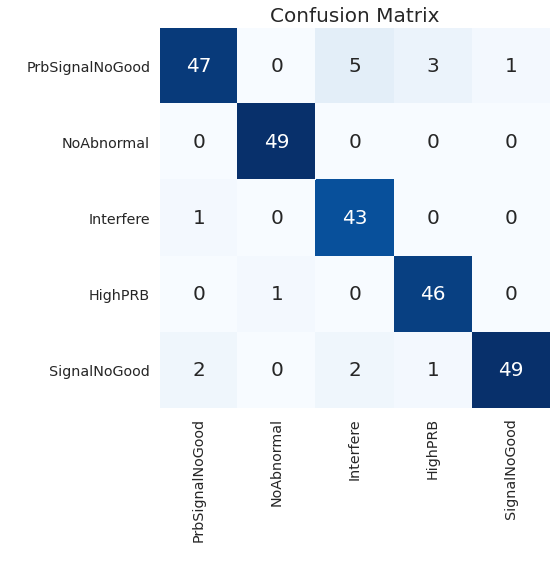

In [ ]:
import seaborn as sns
# label_font = {'size':'18'}  # Adjust to fit
sns.set(font_scale=1.3) # Adjust to fit

matrix = confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason'],
                          labels=predict_submission['predict_reason'].unique()
                    )
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 20})

sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=predict_submission['predict_reason'].unique(),
            yticklabels=predict_submission['predict_reason'].unique(),
            fmt='g')

# plt.ylabel('Predict Reason')
# plt.xlabel('COTT Reason')
plt.ylabel('   ')
plt.xlabel('  ')
plt.title('Confusion Matrix',fontsize=20)

In [ ]:
predict_submission[predict_submission['cott_reason'].isin(['NoAbnormal'])].groupby(['predict_reason','cott_reason']).count()

,,cott,predict_reason_code,cott_reason_code
predict_reason,cott_reason,,,
HighPRB,NoAbnormal,1,1,1
NoAbnormal,NoAbnormal,49,49,49


In [ ]:
pd.set_option('display.max_rows', predict_submission.shape[0]+1)
predict_submission.head(10)

,cott,predict_reason_code,predict_reason,cott_reason,cott_reason_code
0,M2204300189,3,PrbSignalNoGood,PrbSignalNoGood,3
1,M2204290018,2,NoAbnormal,NoAbnormal,2
2,M2204250228,2,NoAbnormal,NoAbnormal,2
3,M2204281321,1,Interfere,Interfere,1
4,M2204271002,1,Interfere,Interfere,1
5,M2204300636,0,HighPRB,HighPRB,0
6,M2204300201,4,SignalNoGood,SignalNoGood,4
7,M2204300387,4,SignalNoGood,SignalNoGood,4
8,M2204240613,2,NoAbnormal,NoAbnormal,2
9,M2204261519,4,SignalNoGood,Interfere,1


In [ ]:
predict_submission.to_csv('./predict_denseCBAM_'+today+'_v'+version+'.csv', index = False)

In [ ]:
#jupyter nbconvert --to html dense_cott_v2.ipynb